In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import load_model
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
! rm -rf test; mkdir test
! unzip -q '/content/drive/My Drive/cs230 project/dataset/webcam amil.zip' -d test
! unzip -q '/content/drive/My Drive/cs230 project/dataset/webcam paki.zip' -d test

In [0]:
def get_datagen(dataset):
    return ImageDataGenerator().flow_from_directory(
              dataset,
              target_size=(48,48),
              color_mode='grayscale',
              shuffle = True,
              class_mode='categorical',
              batch_size=32)

In [0]:
from skimage import io, transform

X_test_gen    = get_datagen('/content/test')

X_test = np.zeros((len(X_test_gen.filepaths), 48, 48, 1))
Y_test = np.zeros((len(X_test_gen.filepaths), 7))
for i in range(0,len(X_test_gen.filepaths)):
  x = io.imread(X_test_gen.filepaths[i], as_gray=True)
  X_test[i,:] = transform.resize(x, (48,48,1))
  Y_test[i,X_test_gen.classes[i]] = 1

Found 204 images belonging to 7 classes.


In [0]:
model = load_model('/content/drive/My Drive/cs230 project/models/webcam-SGD_LR_0.01000-EPOCHS_100-BS_128-DROPOUT_0.35test_acc_0.698.h5')
#model = load_model('/content/drive/My Drive/cs230 project/models/tl/ResNet-BEST-73.2.h5')

In [0]:
y_pred_probs = model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)
y_true = Y_test.argmax(axis=1)

In [0]:
incorrect = np.count_nonzero(y_pred-y_true)
print("Accuracy on test images: {:.2%}".format(1.0 - incorrect/len(y_true)))

Accuracy on test images: 65.69%


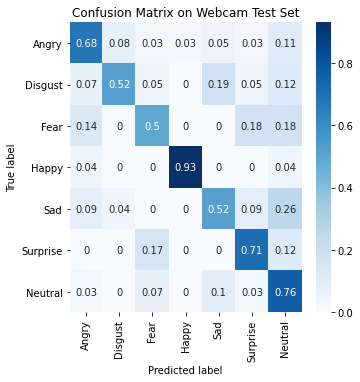

In [0]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

emotions = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

cmat_df_test=pd.DataFrame(
  confusion_matrix(y_true, y_pred, normalize='true').round(2),
  index=emotions.values(), 
  columns=emotions.values()
  )

plt.figure(figsize=(5,5))
heatmap(cmat_df_test,annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.title('Confusion Matrix on Webcam Test Set')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [0]:
emotions = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

In [0]:
for i in range(0, len(y_pred)):
  if emotions[y_true[i]] == 'Happy' and emotions[y_pred[i]] == 'Happy':
      print(i)

# Error Analysis

3 happy/happy-255248-0015.png
[0.07 0.   0.02 0.71 0.13 0.   0.06]


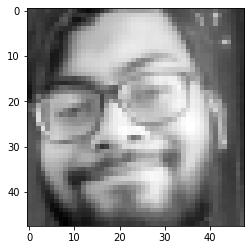

<Figure size 432x288 with 0 Axes>

In [0]:
i=102

print(X_test_gen.filenames[i])
plt.imshow(X_test[i].reshape(48,48),cmap='gray')
plt.figure()
print(y_pred_probs[i].round(2))

# Saliency Map
We copied this code from: https://www.kaggle.com/blargl/simple-occlusion-and-saliency-maps and made some modifications.
Original paper: https://arxiv.org/abs/1311.2901

In [0]:
def iter_occlusion(image, size=8):
    occlusion = np.full((size * 5, size * 5, 1), [0.5], np.float32)
    occlusion_center = np.full((size, size, 1), [0.5], np.float32)
    occlusion_padding = size * 2

    # print('padding...')
    image_padded = np.pad(image, ( \
                        (occlusion_padding, occlusion_padding), (occlusion_padding, occlusion_padding), (0, 0) \
                        ), 'constant', constant_values = 0.0)

    for y in range(occlusion_padding, image.shape[0] + occlusion_padding, size):
        for x in range(occlusion_padding, image.shape[1] + occlusion_padding, size):
            tmp = image_padded.copy()

            tmp[y - occlusion_padding:y + occlusion_center.shape[0] + occlusion_padding, \
                x - occlusion_padding:x + occlusion_center.shape[1] + occlusion_padding] \
                = occlusion

            tmp[y:y + occlusion_center.shape[0], x:x + occlusion_center.shape[1]] = occlusion_center

            yield x - occlusion_padding, y - occlusion_padding, \
                  tmp[occlusion_padding:tmp.shape[0] - occlusion_padding, occlusion_padding:tmp.shape[1] - occlusion_padding]

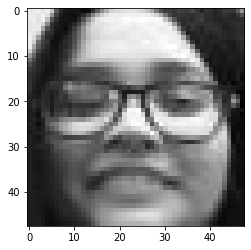

In [0]:
i = 126
data = X_test[i]
correct_class = np.argmax(Y_test[i])

# input tensor for model.predict
inp = data.reshape(1,48,48,1)
# image data for matplotlib's imshow
img = data.reshape(48,48)
# occlusion
img_size = img.shape[0]
occlusion_size = 4
_ = plt.imshow(img,cmap='gray')

In [0]:
print('occluding...')

heatmap = np.zeros((img_size, img_size), np.float32)
class_pixels = np.zeros((img_size, img_size), np.int16)

from collections import defaultdict
counters = defaultdict(int)

for n, (x, y, img_float) in enumerate(iter_occlusion(data, size=occlusion_size)):   
    X = img_float.reshape(1,48,48,1)
    out = model.predict(X)
    print('#{}: {} @ {} (correct class: {})'.format(n, np.argmax(out), np.amax(out), out[0][correct_class]))
    #print('x {} - {} | y {} - {}'.format(x, x + occlusion_size, y, y + occlusion_size))

    heatmap[y:y + occlusion_size, x:x + occlusion_size] = out[0][correct_class]
    class_pixels[y:y + occlusion_size, x:x + occlusion_size] = np.argmax(out)
    counters[np.argmax(out)] += 1

pred = model.predict(inp)
print('Correct class: {}'.format(correct_class))
print('Predicted class: {} (prob: {})'.format(np.argmax(pred), np.amax(out)))

print('Predictions:')
for class_id, count in counters.items():
    print('{}: {}'.format(class_id, count))

In [0]:
# Reverse heatmap so that red means important, blue means not
heatmap=1-heatmap

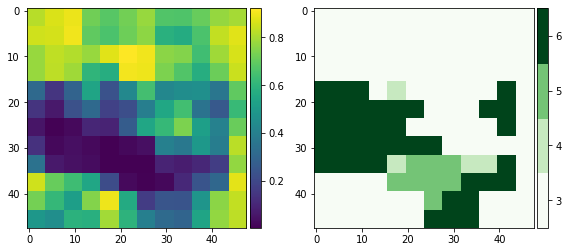

In [0]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import BoundaryNorm
from matplotlib.colorbar import ColorbarBase
from matplotlib import cm

fig = plt.figure(figsize=(8, 8))

ax1 = plt.subplot(1, 2, 1, aspect='equal')
hm = ax1.imshow(heatmap)

ax2 = plt.subplot(1, 2, 2, aspect='equal')


vals = np.unique(class_pixels).tolist()
bounds = vals + [vals[-1] + 1]  # add an extra item for cosmetic reasons

custom = cm.get_cmap('Greens', len(bounds)) # discrete colors

norm = BoundaryNorm(bounds, custom.N)

cp = ax2.imshow(class_pixels, norm=norm, cmap=custom)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
cbar1 = plt.colorbar(hm, cax=cax1)

divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="5%", pad=0.05)
cbar2 = ColorbarBase(cax2, cmap=custom, norm=norm,
                         # place the ticks at the average value between two entries
                         # e.g. [280, 300] -> 290
                         # so that they're centered on the colorbar
                         ticks=[(a + b) / 2.0 for a, b in zip(bounds[::], bounds[1::])],
                         boundaries=bounds, spacing='uniform', orientation='vertical')

cbar2.ax.set_yticklabels([n for n in np.unique(class_pixels)])

fig.tight_layout()

plt.show()

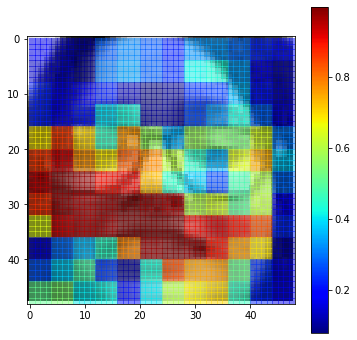

In [0]:
import cv2

plt.figure(figsize=(6, 6))

plt.imshow(img, cmap=cm.gray)
plt.pcolormesh(heatmap, cmap=plt.cm.jet, alpha=0.50)
plt.colorbar().solids.set(alpha=1)

plt.show()

# GradCAM

In [0]:
import cv2

for i in range(0, len(y_pred)):
  if emotions[y_true[i]] == 'Happy' and emotions[y_pred[i]] == 'Happy':
    single_example = X_test[i]
    label = 3

    LAST_LAYER = "conv3"
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAST_LAYER).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(single_example.reshape(1,48,48,1))
        loss = preds[:,label]

    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = np.ones(output.shape[0: 2], dtype = np.float32)
    for i, w in enumerate(weights):
        cam += w * output[:, :, i]
    cam = cv2.resize(cam.numpy(), (48, 48))
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

    plt.imshow(single_example.reshape(48,48),cmap='gray')
    plt.imshow(cam,cmap='gray',alpha=0.5)
    plt.figure()

# buggy code

NameError: ignored

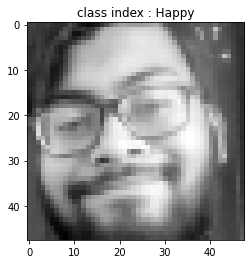

In [0]:
y_test = Y_test.argmax(axis=1)

# Select an image to show the saliency map on
indx=102
plt.title(label = "class index : {}".format(emotions[y_test[indx]]))
plt.imshow(X_test[indx].reshape(48,48),cmap='gray')
target_image = X_test[indx].reshape(1,48,48,1)

weights = model.weights[-2][:,y_test[indx]]
output_conv4_model = Model(inputs=model.input, outputs=model.get_layer("conv3").output)
layer_feature_maps = output_conv4_model.predict(target_image)

#TODO: vectorize
cam = 0
for k in range(layer_feature_maps.shape[-1]): 
     cam += weights[k]*layer_feature_maps[:,:,:,k]


cam = np.reshape(cam,[12,12,1])
#plt.imshow(np.resize(cam,(48,48)))
cam_resized= tf.image.resize(cam,[48,48])
plt.imshow(target_image.reshape(48,48),cmap='gray')
plt.imshow(cam_resized.numpy().reshape(48,48),alpha=0.4)

In [0]:
from tensorflow.keras import backend as K
from tensorflow.keras import Model

indx=102

# # reshape individual image 
single_example = X_test[indx].reshape(1,48,48,1)

# four lines are needed to generate a function that computes the gradients 
# remember that you need to specific which class the image belongs to. 
# this is specified in the example_model_output. 
input_tensors = [model.input]
example_model_output = model.output[0][y_test[indx]]
gradients = model.optimizer.get_gradients(example_model_output, model.input)
compute_gradients = K.function(inputs = input_tensors, outputs = gradients)

gradient_fun  = Model(inputs= model.input, outputs=gradients)
gradients_value = gradient_fun(single_example.astype("float32"))

# plot the gradient values 
plt.figure()
plt.imshow(single_example.reshape(48,48))
plt.show()
plt.figure()
plt.imshow(gradients_value.numpy().reshape(48,48))
plt.show()